First, load in the dataset and relevant functions:

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the data
df = pd.read_csv('/home/laaria/Desktop/REPOSITORIES/PRACTICE-NOTEBOOKS/DATA/mobile_app_attribution.csv')

# Data preview
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [5]:
print(df['is_attributed'].value_counts())

is_attributed
0    99773
1      227
Name: count, dtype: int64


As you can see, over 99% of the data is the negative case.

In [6]:
# Define appropriate X and y
y = df['is_attributed']
X = df[['ip', 'app', 'device', 'os', 'channel']]
X = pd.get_dummies(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## SMOTE
SMOTE stands for Synthetic Minority Oversampling. Here, rather then simply oversampling the minority class with replacement (which simply adds duplicate cases to the dataset), the algorithm generates new sample data by creating 'synthetic' examples that are combinations of the closest minority class cases. You can read more about SMOTE here.

SMOTE is generally a powerful way to deal with class imbalances, but it runs into computational issues when you have a large number of features due to the curse of dimensionality.

Implementing this technique is very easy using the imblearn package:

In [7]:
from imblearn.over_sampling import SMOTE

# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

is_attributed
0    99773
1      227
Name: count, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

is_attributed
0    74841
1    74841
Name: count, dtype: int64


LogisticRegression(C=1e+20, fit_intercept=False)
AUC for 0.1: 0.7180601825199839
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
AUC for 0.25: 0.7663214531761685
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
AUC for 0.33: 0.7825355555345835
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
AUC for 0.5: 0.8044693330565019
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
AUC for 0.7: 0.8193268042015458
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
AUC for even: 0.832726191712045
----------------------------------------------------------------------------------

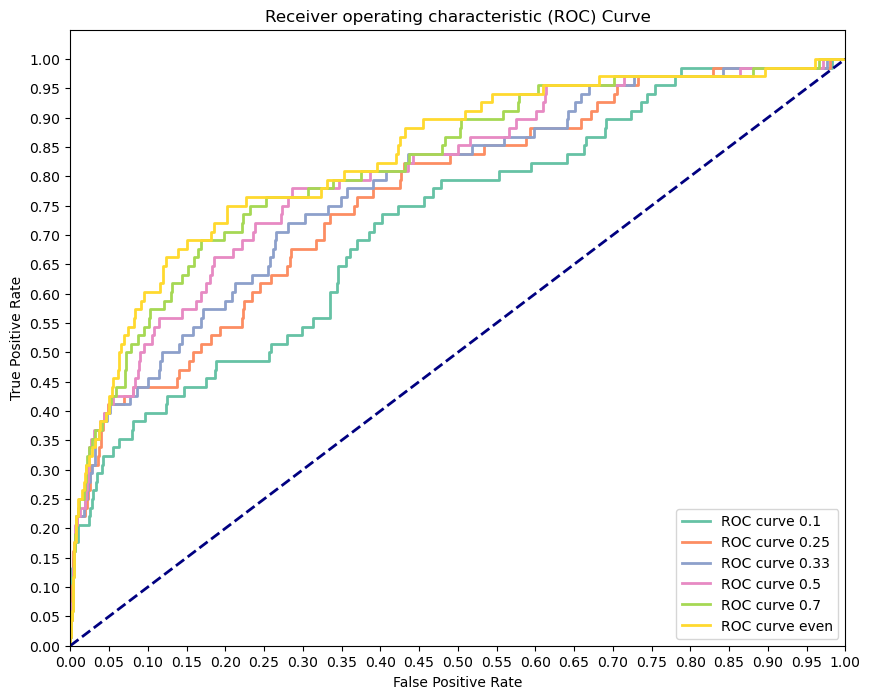

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
# Now let's compare a few different ratios of minority class to majority class
ratios = [0.1, 0.25, 0.33, 0.5, 0.7, 1]
names = ['0.1', '0.25', '0.33','0.5','0.7','even']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, ratio in enumerate(ratios):
    # Fit a model
    smote = SMOTE(sampling_strategy=ratio)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 
    logreg = LogisticRegression(fit_intercept=False, C=1e20, solver ='lbfgs')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()